# Семинар 7 - Линейная регрессия

##### Краткий синопсис:
1. Линейная Регрессия
2. GLM (на примере OLS для нейронауки)
3. RVM 

http://scikit-learn.org/stable/modules/linear_model.html

In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
np.random.seed(42)
warnings.filterwarnings("ignore")

# 1. Линейная регрессия.

### Построим сигнал, который представляет собой модулированную синусоиду

In [2]:
a1 = 10.
a2 = 1.
w1 = 1.
w2 = 16.
N = 256

In [3]:
x = np.linspace(-4, 4, N)
f = a1 * np.sin(w1 * x) + a2 * np.sin(w2 * x)

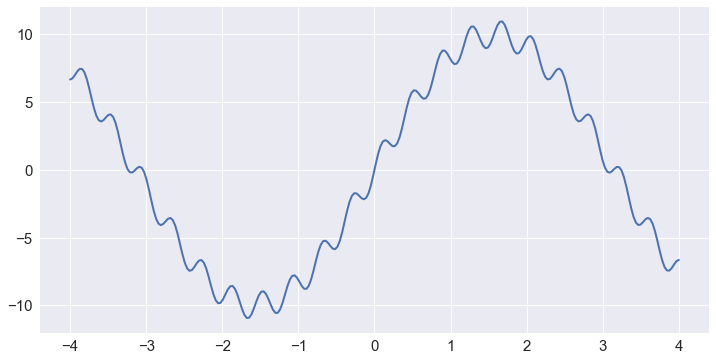

In [4]:
plt.figure(figsize=(12,6))
plt.plot(x, f, linewidth=2)

Сгенерируем оператор, который определяется матрицей $A$ ленточного вида.

Такой оператор соответствует как если бы сигнал обработали moving average, т.е. производит усреднение по некоторому скользящему окну.

In [5]:
A = np.eye(N)
for k in range(1, 15):
    A += np.diag(np.ones(N), k=k)[:N, :N]
    A += np.diag(np.ones(N), k=-k)[:N, :N]

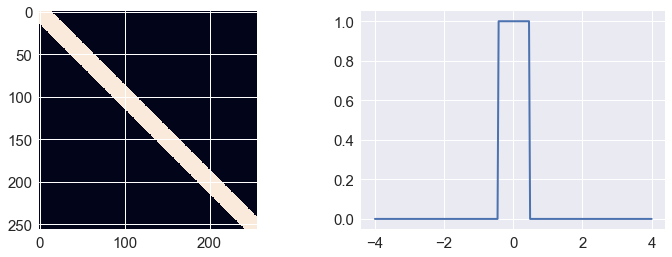

In [6]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].imshow(A)
axs[1].plot(x, A[N // 2,:], linewidth=2)

Сгенерируем выборку $xi$ умножив нашу диагональную матрицу $A$ на наш сигнал $f$.

Т.е. эффективно сгладив сигнал moving average.

In [7]:
sigma = 2
noise = sigma * np.random.randn(N)
xi = np.dot(A, f) + noise

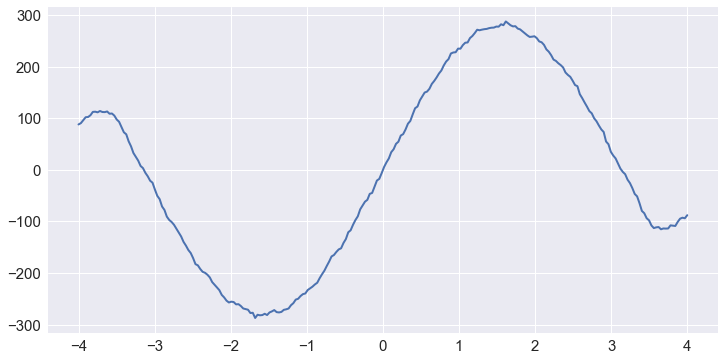

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(x, xi, linewidth=2)

### 1.1 LEAST SQUARES ESTIMATE

Первым делом попробует восстановить сигнал с помощью LSE, т.е. с помощью метода наименьших квадратов.

$$Af = \xi$$

Матрица псевдорешения(псевдообратная матрица):

$$A^+ = (A^T A)^{-1} A^T$$

Тогда решение можно представить следующим образом:

$$f = A^+ \xi$$

In [9]:
R = np.dot(
        np.linalg.inv(np.dot(A.T, A)),
        A.T
    ) # <YOUR_CODE>
Rxi = np.dot(R, xi)

Text(0.5,1,'Восстановленный сигнала с помощью LSE')

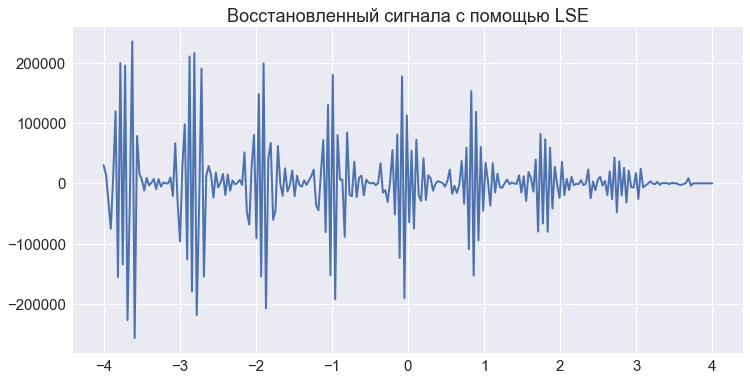

In [10]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi, linewidth=2)
plt.title('Восстановленный сигнала с помощью LSE')

### Wow wow

#### WTF?

Наш вариант реализации псевдообратной является неканоничным и страдает из-за плохих собственных значений.
Поэтому лучше использовать специализированные пакеты, которые более эффективно вычисляют псевдообратные матрицы.

https://en.wikipedia.org/wiki/Generalized_inverse

In [11]:
np.linalg.pinv?

In [12]:
R_pinv = np.linalg.pinv(A) # <YOUR_CODE>
R_pinv_xi = np.dot(R_pinv, xi)

Text(0.5,1,'Восстановленный сигнал с помощью np.linalg.pinv')

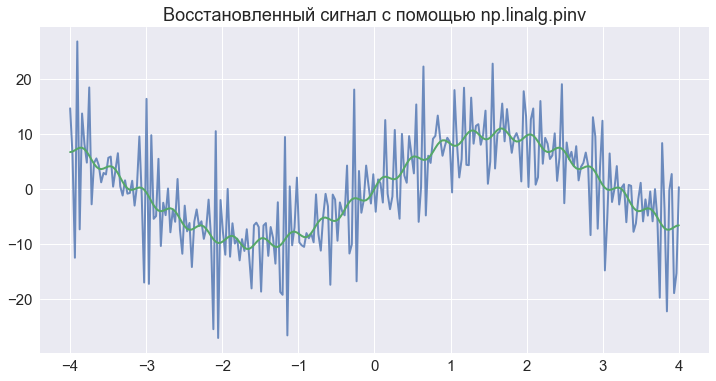

In [13]:
plt.figure(figsize=(12,6))
plt.plot(x, R_pinv_xi, linewidth=2, alpha=0.8)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал с помощью np.linalg.pinv')

### NOT QUITE THERE YET. REGULARIZE!

In [14]:
c = 0.001
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    ) # <YOUR_CODE>
Rxi_reg = np.dot(R_reg, xi)

Text(0.5,1,'Восстановленный сигнал при включении регуляризации')

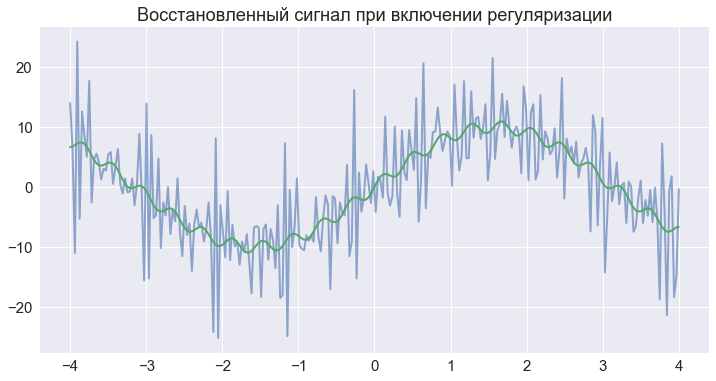

In [15]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

#### Как выбирать коэффициент регуляризации?

In [16]:
reg_coeffs = np.linspace(0.5, 20, 80)
reg_loss = []
for c in reg_coeffs:
    R_reg = np.dot(
            np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
            A.T
        ) # <YOUR_CODE>
    Rxi_reg = np.dot(R_reg, xi)
    loss = np.sum((f - Rxi_reg)**2)
    reg_loss.append(loss)

Text(0.5,1,'MSE в зависимости от коэффициента регуляризации')

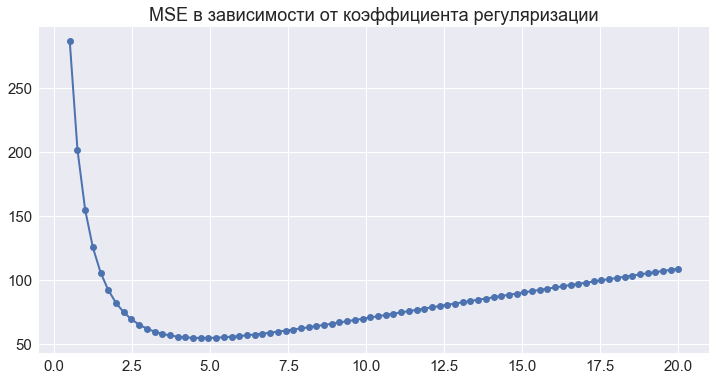

In [17]:
plt.figure(figsize=(12,6))
plt.plot(reg_coeffs, reg_loss, 'o-', linewidth=2)
plt.title('MSE в зависимости от коэффициента регуляризации')

In [18]:
reg_coeffs[np.argmin(reg_loss)]

4.69620253164557

In [19]:
c = 4.69
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    ) # <YOUR_CODE>
Rxi_reg = np.dot(R_reg, xi)

Text(0.5,1,'Восстановленный сигнал при включении регуляризации')

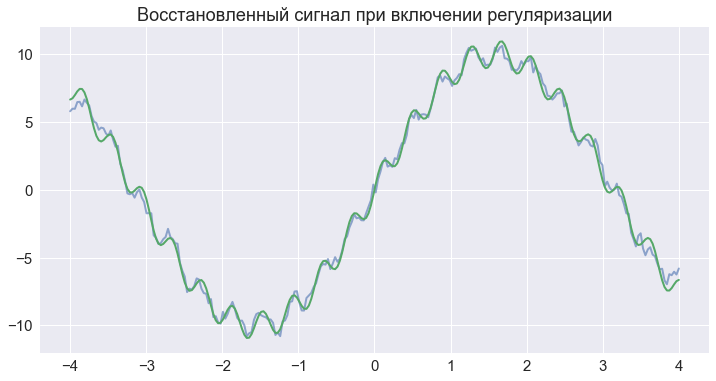

In [20]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

###  SVD

$$A_{n \times m } = U_{m \times m } \Sigma_{m \times n } V_{n \times n }$$

In [21]:
U, S, V = np.linalg.svd(A)

Text(0.5,1,'Собственные числа оператора A')

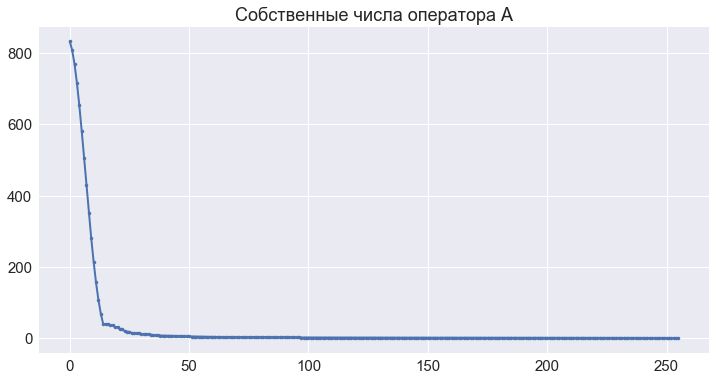

In [22]:
plt.figure(figsize=(12,6))
plt.plot(S**2, '.-', linewidth=2)
plt.title('Собственные числа оператора A')

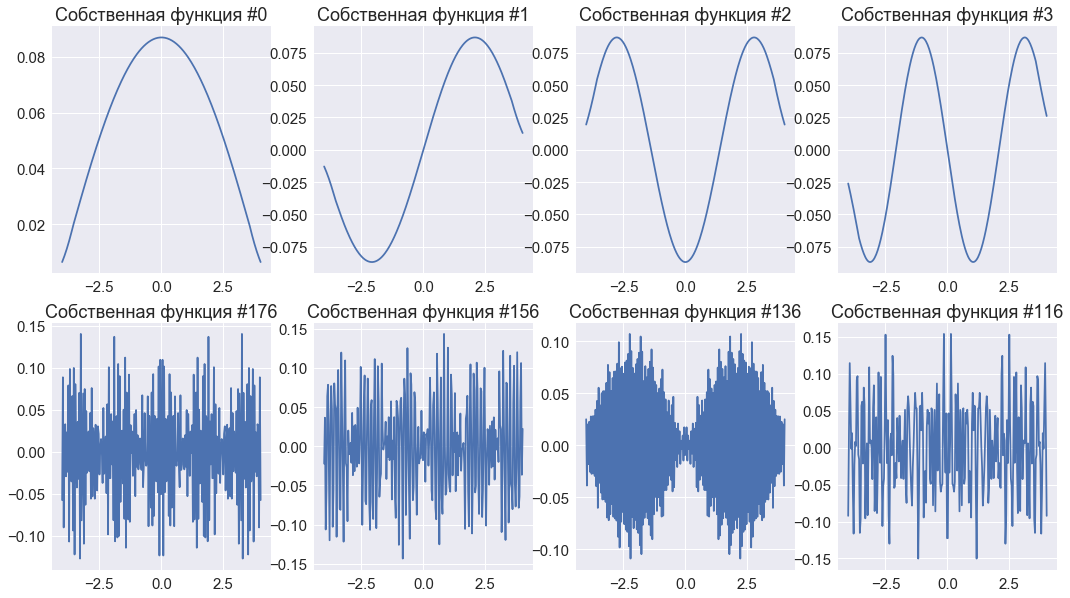

In [23]:
fig, axs = plt.subplots(figsize=(18, 10), ncols=4, nrows=2)
for i in range(4):
    axs[0, i].plot(x, V[i])
    axs[0, i].set_title('Собственная функция #{}'.format(i))
for i in range(4):
    axs[1, i].plot(x, V[N-(4 + i) * 20])
    axs[1, i].set_title('Собственная функция #{}'.format(N-(4 + i) * 20))

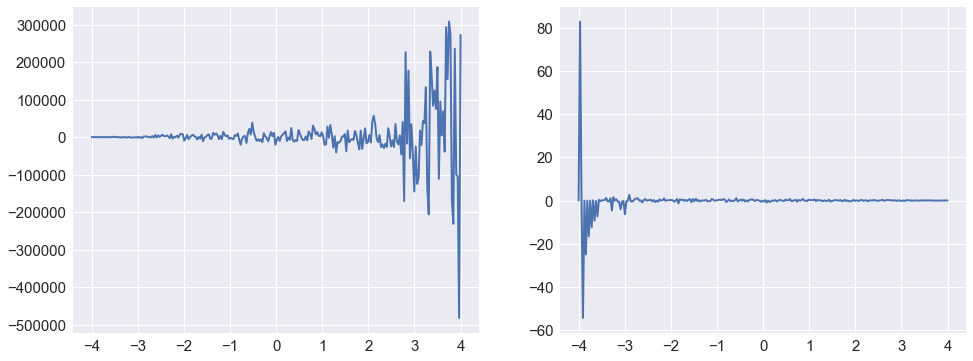

In [24]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(x, np.dot(V, Rxi), linewidth=2) # <YOUR_CODE>
axs[1].plot(x, np.dot(V, Rxi_reg), linewidth=2) # <YOUR_CODE>

### Переходим к базису оператора A и сделаем все те же самые трюки что делали раньше

Как перейти к базису оператора A имея матрицы $U$, $V$ и $S$?

In [25]:
f_wave = np.dot(V, f) # <YOUR_CODE>
noise_wave = np.dot(V, noise) # <YOUR_CODE>

In [26]:
A_wave = np.diag(S)

In [27]:
xi_wave = np.dot(A_wave, f_wave) + noise_wave

Text(0.5,1,'Отфильтрованный сигнал при переходе ')

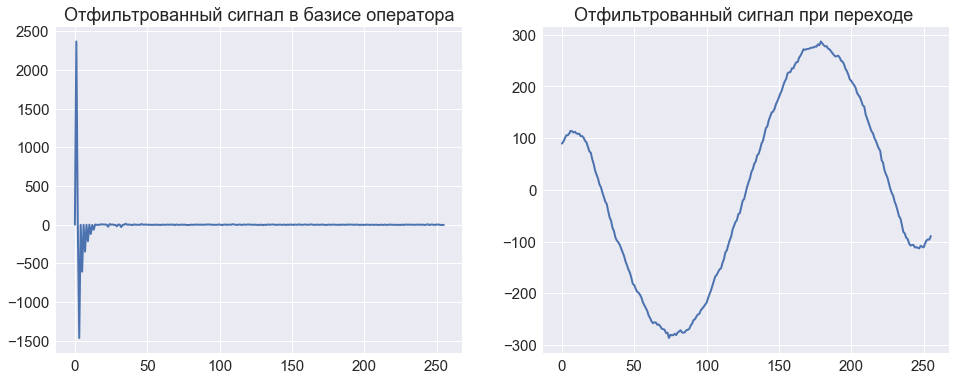

In [28]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)

axs[0].plot(xi_wave, linewidth=2)
axs[0].set_title('Отфильтрованный сигнал в базисе оператора')

# Теперь у нас есть xi_wave -- сигнал в базисе оператора A
# покажем, что это тот самый отфильтрованный сигнал, перейдя обратно в изначальный базис
axs[1].plot(np.dot(V.T, xi_wave), linewidth=2) # <YOUR_CODE>
axs[1].set_title('Отфильтрованный сигнал при переходе ')

А теперь будем будем делать обратные в этом новом базисе.

#Formulae

In [29]:
R_wave = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave)),
        A_wave.T
) # <YOUR_CODE>
R_wave_xi = np.dot(R_wave, xi_wave)

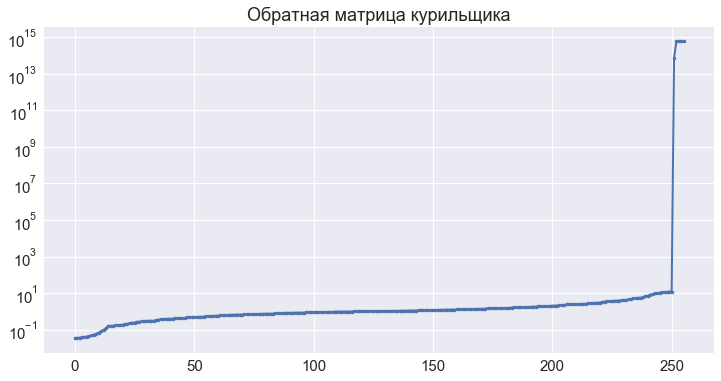

In [30]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_wave), '.-', linewidth=2)
plt.title('Обратная матрица курильщика')
plt.yscale('log')

Text(0.5,1,'Восстановленный сигнал ')

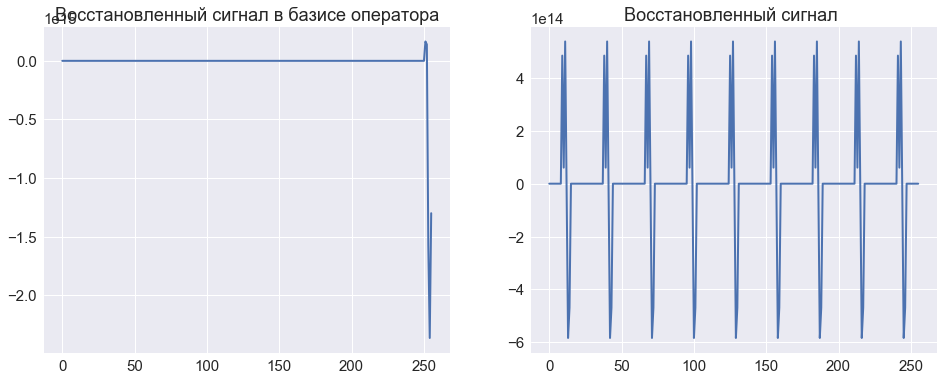

In [31]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(np.dot(V.T, R_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

Опять проблемы с точностью :(

In [32]:
R_pinv_wave = np.linalg.pinv(A_wave)
R_pinv_wave_xi = np.dot(R_pinv_wave, xi_wave)

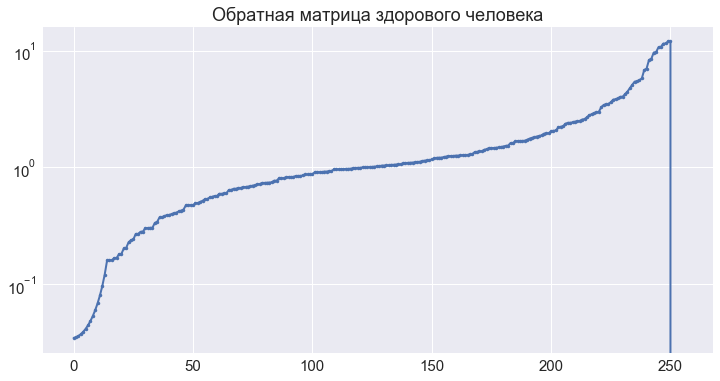

In [33]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_pinv_wave), '.-', linewidth=2)
plt.title('Обратная матрица здорового человека')
plt.yscale('log')

Text(0.5,1,'Восстановленный сигнал ')

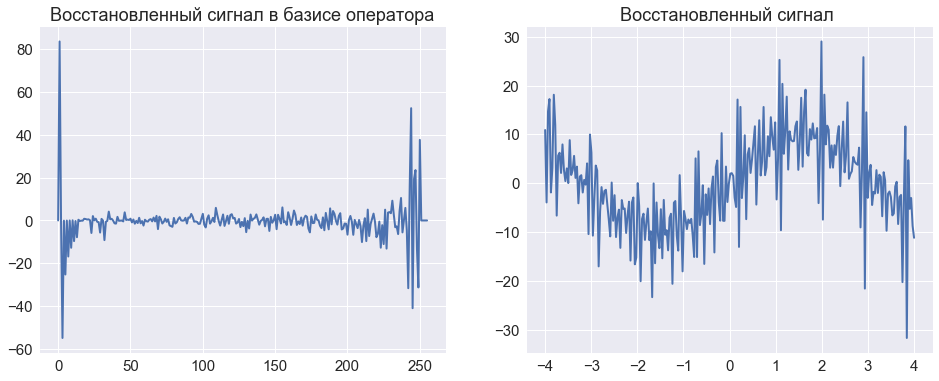

In [34]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_pinv_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(x, np.dot(V.T, R_pinv_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

In [35]:
c = 4.68
R_wave_reg = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave) + c * np.eye(N)),
        A_wave.T
    ) # <YORE CODE>
R_wave_xi_reg = np.dot(R_wave_reg, xi_wave)

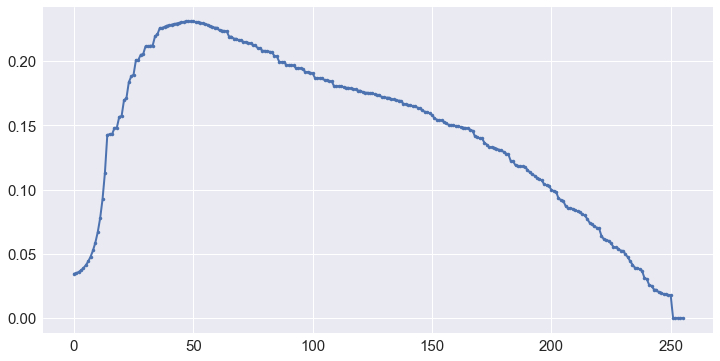

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(np.diag(R_wave_reg), '.-', linewidth=2)

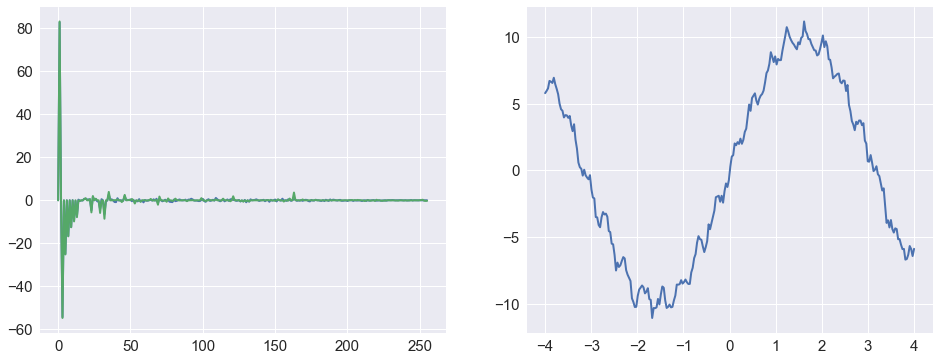

In [37]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi_reg, linewidth=2)
axs[0].plot(f_wave, linewidth=2)
axs[1].plot(x, np.dot(V.T, R_wave_xi_reg), linewidth=2)

#  3. GLM (на примере OLS для нейронауки)

A permuted Ordinary Least Squares algorithm is run at each voxel in order to detemine whether or not it behaves differently under a “face viewing” condition and a “house viewing” condition. We consider the mean image per session and per condition. Otherwise, the observations cannot be exchanged at random because a time dependance exists between observations within a same session (see [1] for more detailed explanations).

The example shows the small differences that exist between Bonferroni-corrected p-values and family-wise corrected p-values obtained from a permutation test combined with a max-type procedure [2]. Bonferroni correction is a bit conservative, as revealed by the presence of a few false negative

Пример из `nilern`: https://nilearn.github.io/decoding/decoding_intro.html

[1] Winkler, A. M. et al. (2014).
Permutation inference for the general linear model. Neuroimage.

[2] Anderson, M. J. & Robinson, J. (2001).
Permutation tests for linear models. Australian & New Zealand Journal of Statistics, 43(1), 75-88. (http://avesbiodiv.mncn.csic.es/estadistica/permut2.pdf)

##### Работаем с данными из датасета Haxby

Haxby et al. (2001): Faces and Objects in Ventral Temporal Cortex (fMRI) - височная кора головного мозга 
https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_stimuli.html

![Датасет](https://www.researchgate.net/profile/Martin_Hebart/publication/270749420/figure/fig2/AS:272567755866138@1441996625521/Results-of-analyses-on-Haxby-2001-data-set-A-Confusion-matrix-reflecting-the-confusion.png)

Brain mapping

https://youtu.be/k61nJkx5aDQ?t=15

In [38]:
#Load Haxby dataset
import nilearn
import pandas as pd
from nilearn import datasets
from scipy.misc import imread
from nilearn import datasets
from nilearn.plotting import show

In [39]:
haxby_dataset = datasets.fetch_haxby(subjects=[2], fetch_stimuli=True)
haxby_dataset.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

In [40]:
stimulus_information = haxby_dataset.stimuli

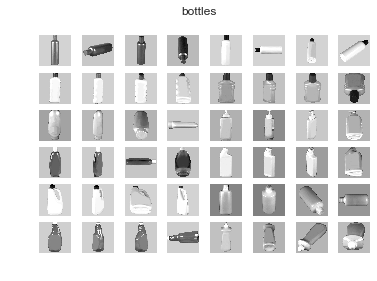

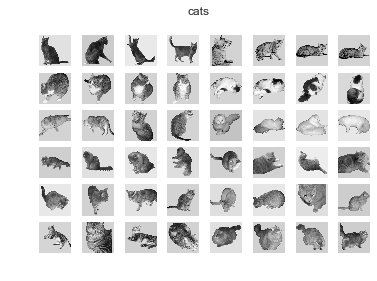

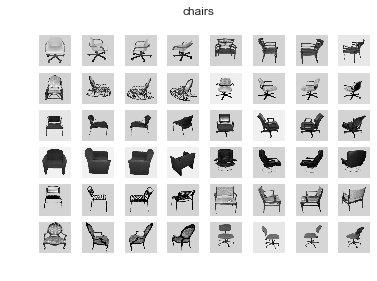

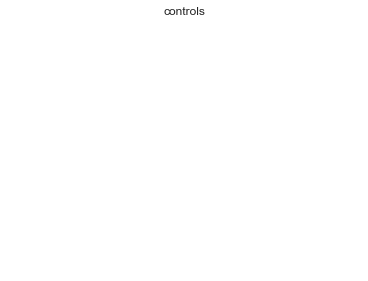

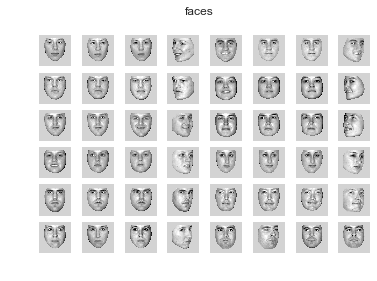

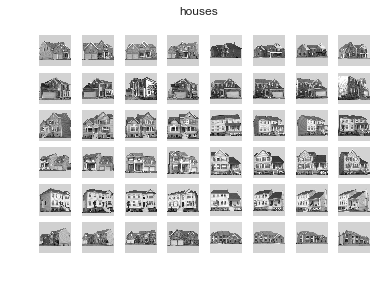

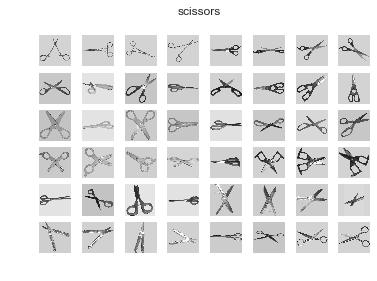

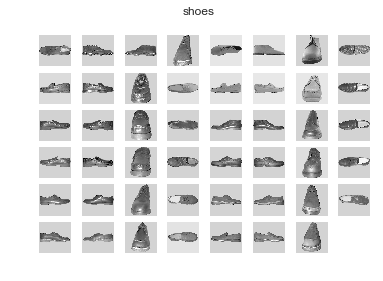

In [41]:
for stim_type in sorted(stimulus_information.keys()):
    if stim_type == b'controls':
        continue
    file_names = stimulus_information[stim_type]
    plt.figure()
    for i in range(48):
        plt.subplot(6, 8, i + 1)
        try:
            plt.imshow(imread(file_names[i]), cmap=plt.cm.gray)
        except:
            pass
        plt.axis("off")
    plt.suptitle(stim_type)
show()

`haxby_dataset.func` содержит картинки мозга в разные моменты времени.

In [42]:
print(haxby_dataset.func[0])
img_temp = nilearn.image.load_img(haxby_dataset.func[0])
print(img_temp)

/home/acappello/nilearn_data/haxby2001/subj2/bold.nii.gz
<class 'nibabel.nifti1.Nifti1Image'>
data shape (40, 64, 64, 1452)
affine: 
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [   4   40   64   64 1452    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   3.5  3.75 3.75 2.5  0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 1578.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 

`haxby_dataset.session_target` содержит метки.

In [43]:
print(haxby_dataset.session_target[0])
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']
print(behavioral.shape)
behavioral.head()

/home/acappello/nilearn_data/haxby2001/subj2/labels.txt
(1452, 2)


,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


In [44]:
# Размер одного фмрт изображения, где первые 3 начения это разрешения 3D картинки и 1452 отсчета по времени
print(img_temp.shape)
# И для каждого отсчета известны ключи (визуальные стимулы) для task-based fMRI 
print(conditions.shape)

(40, 64, 64, 1452)
(1452,)


#### Картинка мозга, который выглядит как чужой

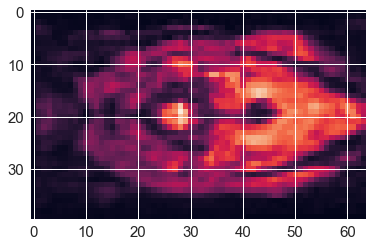

In [45]:
plt.imshow(img_temp.dataobj[..., 10, 0])

![Зачем мы маскируем](http://nilearn.github.io/_images/masking.jpg)

Выберем только нужные вокселы для анализа (домножим 4D массивы на маску):

![Mask for fMRI series](https://nilearn.github.io/_images/sphx_glr_plot_visualization_0021.png)

In [46]:
# mask data
mask_filename = haxby_dataset.mask
from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8, mask_img=mask_filename, memory='nilearn_cache', memory_level=1)  # cache options
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)

In [47]:
# Теперь у нас есть 2D массив, который мы и будем использовать в качестве датасета.
# Каждому визуальному ключу ( отсчету времени) соотносятся интенсивности вокселей
# (да, да все воксели кортикальной височной зоны для 1 человека из 6):
print(fmri_masked.shape)
# То есть 
print('Для целикового изображения было бы {}, но мы снизили размерность в 4 раза, наложив маску до 39912'.format(40*64*64))

(1452, 39912)
Для целикового изображения было бы 163840, но мы снизили размерность в 4 раза, наложив маску до 39912


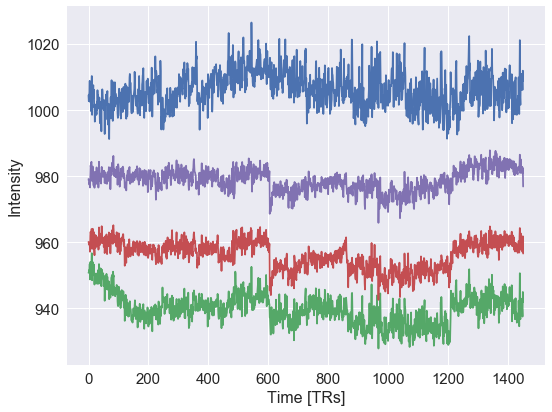

In [48]:
# Посмотрим на то, как выглядит наш сигнал для 1 человека
plt.figure(figsize=(8, 6))
plt.plot(fmri_masked[:, 11132:11136])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

show()

#### Ограничем наши данные домами и лицами

In [49]:
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

conditions = labels['labels']
categories = conditions.unique()
conditions_encoded = np.zeros_like(conditions)

for c, category in enumerate(categories):
    conditions_encoded[conditions == category] = c

sessions = labels['chunks']
condition_mask = conditions.isin(['face', 'house'])
conditions_encoded = conditions_encoded[condition_mask]
fmri_masked = fmri_masked[condition_mask]

# We consider the mean image per session and per condition.
# Otherwise, the observations cannot be exchanged at random because
# a time dependence exists between observations within a same session.
n_sessions = np.unique(sessions).size
grouped_fmri_masked = np.empty((2 * n_sessions,  # two conditions per session
                                fmri_masked.shape[1]))
grouped_conditions_encoded = np.empty((2 * n_sessions, 1))

for s in range(n_sessions):
    session_mask = sessions[condition_mask] == s
    session_house_mask = np.logical_and(session_mask,
                                        conditions[condition_mask] == 'house')
    session_face_mask = np.logical_and(session_mask,
                                       conditions[condition_mask] == 'face')
    grouped_fmri_masked[2 * s] = fmri_masked[session_house_mask].mean(0)
    grouped_fmri_masked[2 * s + 1] = fmri_masked[session_face_mask].mean(0)
    grouped_conditions_encoded[2 * s] = conditions_encoded[
        session_house_mask][0]
    grouped_conditions_encoded[2 * s + 1] = conditions_encoded[
        session_face_mask][0]

In [50]:
# Посмотрим на наши ключи:
# визуальные стимулы показывали сессиями chunks по 9 временных отсчетов (временной интервал около 2.5 секунд). 
# можно, кстати, посчитать, что люди лежали в томографе 2.5*1452/3600=1.008 - почти ровно час
# всего сессий было 12 
labels['labels'].value_counts()

rest            588
cat             108
bottle          108
chair           108
house           108
scissors        108
face            108
scrambledpix    108
shoe            108
Name: labels, dtype: int64

Perform massively univariate analysis with permuted OLS

We use a two-sided t-test to compute p-values, but we keep trace of the effect sign to add it back at the end and thus observe the signed effect

In [51]:
from nilearn.mass_univariate import permuted_ols
neg_log_pvals, t_scores_original_data, _ = permuted_ols(
    grouped_conditions_encoded, grouped_fmri_masked,
    # + intercept as a covariate by default
    n_perm=10000, two_sided_test=True,
    n_jobs=1)  # can be changed to use more CPUs
signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)
signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    signed_neg_log_pvals)

scikit-learn F-scores for comparison

F-test does not allow to observe the effect sign (pure two-sided test)

In [52]:
grouped_fmri_masked.shape

(24, 39912)

In [53]:
from sklearn.feature_selection import f_regression
_, pvals_bonferroni = f_regression(
    grouped_fmri_masked,
    grouped_conditions_encoded)  # f_regression implicitly adds intercept
pvals_bonferroni *= fmri_masked.shape[1]
pvals_bonferroni[np.isnan(pvals_bonferroni)] = 1
pvals_bonferroni[pvals_bonferroni > 1] = 1
neg_log_pvals_bonferroni = -np.log10(pvals_bonferroni)
neg_log_pvals_bonferroni_unmasked = nifti_masker.inverse_transform(
    neg_log_pvals_bonferroni)

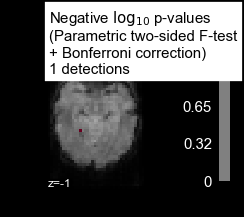

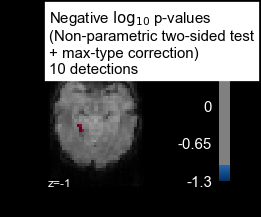

In [54]:
from nilearn.plotting import plot_stat_map, show

# Use the fmri mean image as a surrogate of anatomical data
from nilearn import image
mean_fmri_img = image.mean_img(func_filename)

threshold = -np.log10(0.1)  # 10% corrected

vmax = min(signed_neg_log_pvals.max(),
           neg_log_pvals_bonferroni.max())

# Plot thresholded p-values map corresponding to F-scores
display = plot_stat_map(neg_log_pvals_bonferroni_unmasked, mean_fmri_img,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[-1, ],
                        vmax=vmax)

neg_log_pvals_bonferroni_data = neg_log_pvals_bonferroni_unmasked.get_data()
n_detections = (neg_log_pvals_bonferroni_data > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Parametric two-sided F-test'
         '\n+ Bonferroni correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.1)

# Plot permutation p-values map
display = plot_stat_map(signed_neg_log_pvals_unmasked, mean_fmri_img,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[-1, ],
                        vmax=vmax)

n_detections = (np.abs(signed_neg_log_pvals) > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Non-parametric two-sided test'
         '\n+ max-type correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.1)

show()

### Усилимся и подключим машинку посложнее. 

Будем увеличивать точность классификации и попробуем классфицировать все объекты

In [55]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from collections import defaultdict
from tqdm import tqdm

In [56]:
stimuli = labels['labels']
# identify resting state labels in order to be able to remove them
task_mask = (stimuli != 'rest')
# find names of remaining active labels
categories = stimuli[task_mask].unique()
# extract tags indicating to which acquisition run a tag belongs
session_labels = labels["chunks"][task_mask]

In [57]:
svc = SVC(C=1., kernel="linear")
lr = LogisticRegression()
dummy = DummyClassifier()

In [58]:
cv = 10

mask_names = ['mask_vt', 'mask_face', 'mask_house']

svc_scores = defaultdict(lambda: defaultdict(float))
lr_scores = defaultdict(lambda: defaultdict(float))
dummy_scores = defaultdict(lambda: defaultdict(float))

for mask_name in tqdm(mask_names):
    print("Working on mask %s" % mask_name)
    # For decoding, standardizing is often very important
    mask_filename = haxby_dataset[mask_name][0]
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    masked_timecourses = masker.fit_transform(func_filename)[task_mask]


    for category in tqdm(categories):
        print("Processing %s %s" % (mask_name, category))
        classification_target = (stimuli[task_mask] == category)
        svc_scores[mask_name][category] = cross_val_score(estimator=svc, X=masked_timecourses,
                                                          y=classification_target, cv=cv, 
                                                          groups=session_labels, scoring="roc_auc")

        lr_scores[mask_name][category] = cross_val_score(estimator=lr, X=masked_timecourses,
                                                         y=classification_target, cv=cv, 
                                                         groups=session_labels, scoring="roc_auc")

        dummy_scores[mask_name][category] = cross_val_score(estimator=dummy, X=masked_timecourses,
                                                            y=classification_target, cv=cv, 
                                                            groups=session_labels, scoring="roc_auc")

  0%|          | 0/3 [00:00<?, ?it/s]

Working on mask mask_vt



  0%|          | 0/8 [00:00<?, ?it/s]

Processing mask_vt scissors



 12%|█▎        | 1/8 [00:03<00:23,  3.38s/it]

Processing mask_vt face



 25%|██▌       | 2/8 [00:07<00:22,  3.67s/it]

Processing mask_vt cat



 38%|███▊      | 3/8 [00:11<00:17,  3.57s/it]

Processing mask_vt shoe



 50%|█████     | 4/8 [00:15<00:15,  3.85s/it]

Processing mask_vt house



 62%|██████▎   | 5/8 [00:18<00:10,  3.47s/it]

Processing mask_vt scrambledpix



 75%|███████▌  | 6/8 [00:21<00:07,  3.51s/it]

Processing mask_vt bottle



 88%|████████▊ | 7/8 [00:25<00:03,  3.62s/it]

Processing mask_vt chair



 33%|███▎      | 1/3 [00:44<01:29, 44.54s/it]

Working on mask mask_face



  0%|          | 0/8 [00:00<?, ?it/s]

Processing mask_face scissors



 12%|█▎        | 1/8 [00:00<00:02,  3.45it/s]

Processing mask_face face



 25%|██▌       | 2/8 [00:00<00:01,  3.47it/s]

Processing mask_face cat



 38%|███▊      | 3/8 [00:00<00:01,  3.43it/s]

Processing mask_face shoe



 50%|█████     | 4/8 [00:01<00:01,  3.53it/s]

Processing mask_face house



 62%|██████▎   | 5/8 [00:01<00:00,  3.59it/s]

Processing mask_face scrambledpix



 75%|███████▌  | 6/8 [00:01<00:00,  3.36it/s]

Processing mask_face bottle



 88%|████████▊ | 7/8 [00:02<00:00,  3.24it/s]

Processing mask_face chair



 67%|██████▋   | 2/3 [00:59<00:35, 35.67s/it]

Working on mask mask_house



  0%|          | 0/8 [00:00<?, ?it/s]

Processing mask_house scissors



 12%|█▎        | 1/8 [00:01<00:08,  1.28s/it]

Processing mask_house face



 25%|██▌       | 2/8 [00:02<00:07,  1.22s/it]

Processing mask_house cat



 38%|███▊      | 3/8 [00:03<00:06,  1.26s/it]

Processing mask_house shoe



 50%|█████     | 4/8 [00:04<00:04,  1.24s/it]

Processing mask_house house



 62%|██████▎   | 5/8 [00:05<00:03,  1.02s/it]

Processing mask_house scrambledpix



 75%|███████▌  | 6/8 [00:06<00:01,  1.05it/s]

Processing mask_house bottle



 88%|████████▊ | 7/8 [00:07<00:01,  1.05s/it]

Processing mask_house chair



100%|██████████| 3/3 [01:21<00:00, 31.66s/it]


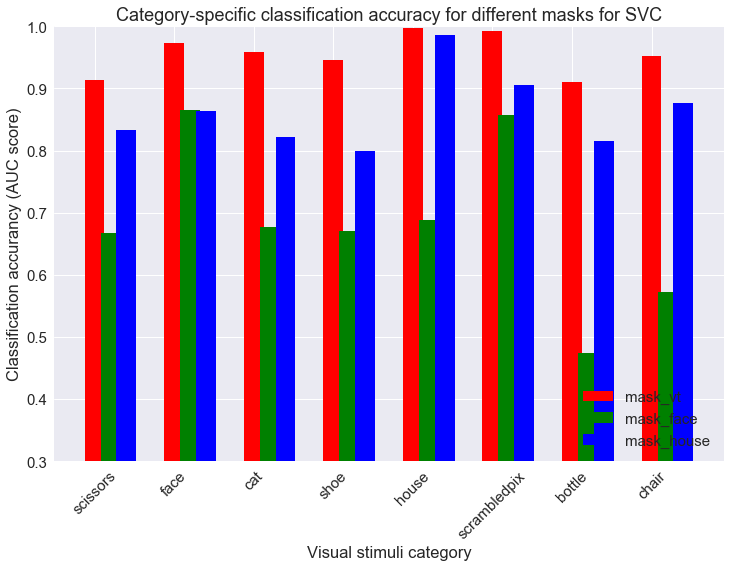

In [59]:
plt.figure(figsize=(12, 8))

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, mask_name in zip('rgb', mask_names):
    score_means = [svc_scores[mask_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=mask_name,
            width=.25, color=color)

    tick_position = tick_position + .2

plt.ylabel('Classification accurancy (AUC score)')
plt.xlabel('Visual stimuli category')
plt.ylim(0.3, 1)
plt.legend(loc='lower right')
plt.title('Category-specific classification accuracy for different masks for SVC')

plt.show()

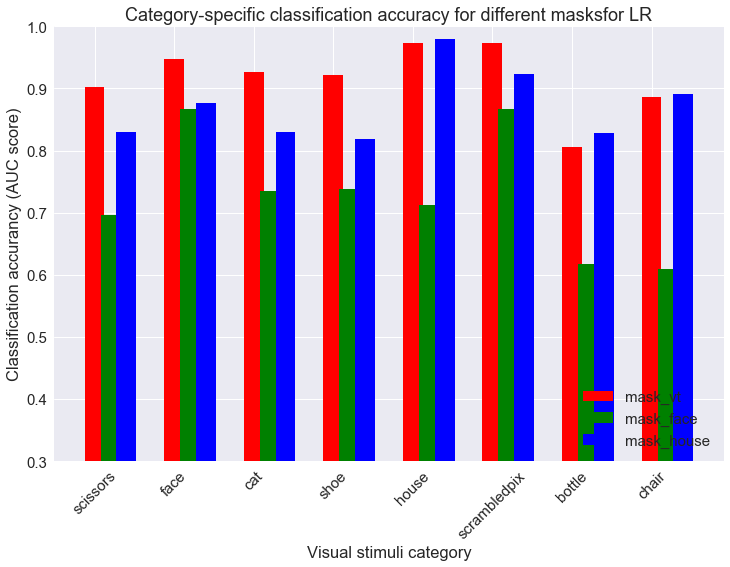

In [60]:
plt.figure(figsize=(12, 8))

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, mask_name in zip('rgb', mask_names):
    score_means = [lr_scores[mask_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=mask_name,
            width=.25, color=color)

    tick_position = tick_position + .2

plt.ylabel('Classification accurancy (AUC score)')
plt.xlabel('Visual stimuli category')
plt.ylim(0.3, 1)
plt.legend(loc='lower right')
plt.title('Category-specific classification accuracy for different masksfor LR')

plt.show()

First subject anatomical nifti image (3D) is at: /home/acappello/nilearn_data/haxby2001/subj2/anat.nii.gz
First subject functional nifti image (4D) is at: /home/acappello/nilearn_data/haxby2001/subj2/bold.nii.gz


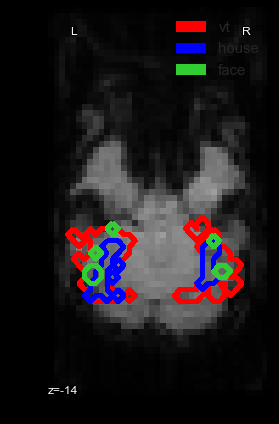

In [61]:
# print basic information on the dataset
print('First subject anatomical nifti image (3D) is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is at: %s' %
      haxby_dataset.func[0])  # 4D data

# Build the mean image because we have no anatomic data
from nilearn import image
func_filename = haxby_dataset.func[0]
mean_img = image.mean_img(func_filename)

z_slice = -14

fig = plt.figure(figsize=(4, 5.4), facecolor='k')

from nilearn.plotting import plot_anat, show
display = plot_anat(mean_img, display_mode='z', cut_coords=[z_slice],
                    figure=fig)
mask_vt_filename = haxby_dataset.mask_vt[0]
mask_house_filename = haxby_dataset.mask_house[0]
mask_face_filename = haxby_dataset.mask_face[0]
display.add_contours(mask_vt_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['red'])
display.add_contours(mask_house_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['blue'])
display.add_contours(mask_face_filename, contours=1, antialiased=False,
                     linewidths=4., levels=[0], colors=['limegreen'])

from matplotlib.patches import Rectangle
p_v = Rectangle((0, 0), 1, 1, fc="red")
p_h = Rectangle((0, 0), 1, 1, fc="blue")
p_f = Rectangle((0, 0), 1, 1, fc="limegreen")
plt.legend([p_v, p_h, p_f], ["vt", "house", "face"])

show()

### Relevance Vector Machine

Метод релевантных векторов -- линейная регрессия под амфетамином с дисперсиями и байесовскими методами.

Задача ставится классическим образом: построить модель зависимости для выборки вида $(X, y) = \{ x_i, y_i \}_{i=1}^N$. Причём мы

$$f(x_i) = w^T x_i$$

#### Вероятностная интерпретация линейной регрессии

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) = \prod\limits_{i=1}^{N} \mathcal{N}(y_i | w^T x_i, \sigma^2) \$$

$$= \frac{1}{\sigma^n (2 \pi)^{n/2}} \exp \left( - \frac{\sum\limits_{i=1}^{N} (y_i - w^T x_i)^2}{2 \sigma^2} \right)$$

Переходим к лагорифму:

$$\log p(y|X, w) = -\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 \rightarrow \max_{w}$$



#### Добавление регуляризации с точки зрения байесовских методов

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) p(w), ~~~ p(w) = \mathcal{N}(w | 0, \alpha^{-1})$$


$$-\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 - \frac{\alpha}{2} ||w||_2^2 \rightarrow \max_{w}$$

Другими словами, l2-регуляризация эквивалентна тому что мы вешаем на веса априорную плотность.



Минусы: \sigma^2$ и $\alpha$ одни для всех признаков и фиксированы(нужна кросс-валидация);

### RVR
или почему бы нам не добавить распределение на параметры распределения параметров распределения?

$$p(w|\alpha) = \mathcal{N}(0, A^{-1}),~~~A=\mathrm{diag}(\alpha_1, \dots, \alpha_m)$$

Тогда используя сложную математику(см. [1]) можно придумать как обучать такую модель где для каждого признака будет своя собственная дисперсия, которая подбирается автоматически.

[1] http://www.machinelearning.ru/wiki/images/4/43/BayesML-2007-textbook-2.pdf

[2] http://www.machinelearning.ru/wiki/index.php?title=RVM

In [62]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [63]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [64]:
from skbayes.rvm_ard_models import RVR
from sklearn.linear_model import LinearRegression
N = 200

In [65]:
x = np.linspace(-5, 5, N)
X = np.vstack([
    x, 
    np.cos(x),
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
    np.random.randn(N) / 10
]).T
Y = 10 * np.sinc(x) + np.random.randn(N)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

Y_test = Y_test[np.argsort(X_test[:, 0])]
X_test = X_test[np.argsort(X_test[:, 0])]

In [66]:
rvm = RVR(kernel='linear')
rvm.fit(X_train, Y_train)

lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
Y_pred_rvm, Y_pred_std = rvm.predict_dist(X_test)
Y_pred_lr = lr.predict(X_test)

mean_squared_error(Y_pred_rvm, Y_test), mean_squared_error(Y_pred_lr, Y_test)

(6.9344176136338955, 7.005385766430743)

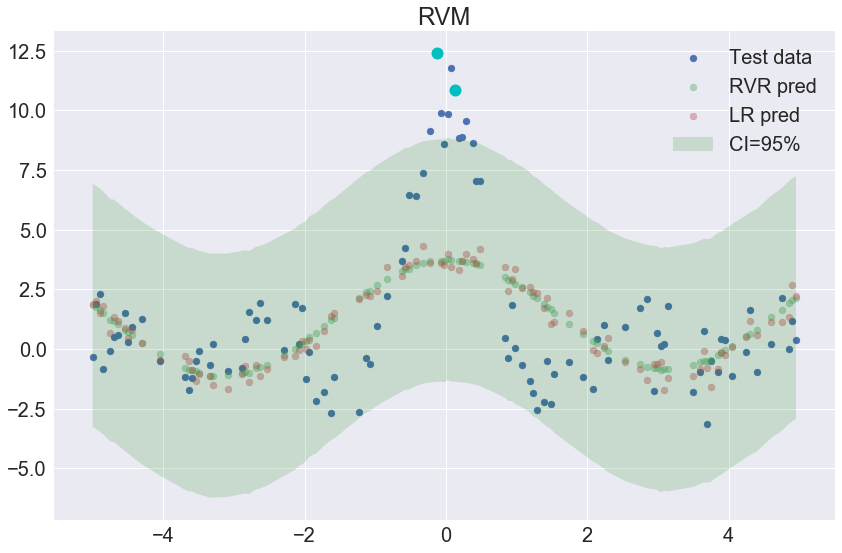

In [68]:
plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "Test data")
plt.scatter(X_test[:, 0], Y_pred_rvm, label = "RVR pred", alpha=0.4)
plt.scatter(X_test[:, 0], Y_pred_lr, label = "LR pred", alpha=0.4)
plt.fill_between(X_test[:, 0], 
                 Y_pred_rvm - 2 * np.sqrt(Y_pred_std), 
                 Y_pred_rvm + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.plot(rvm.relevant_vectors_[:, 0], Y_train[rvm.active_], "co", markersize = 12)
plt.legend()
plt.title("RVM")
plt.show()

### Bias-Variance decomposition

$$\bar{y} = \frac{1}{N} \sum \hat{y}_i$$

$$bias^2=MSE(y, \bar{y})$$

$$variance=\frac{1}{N} \sum MSE(\hat{y}_i, \bar{y})$$

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm

In [70]:
bias_rvr = []
variance_rvr = []
error_rvr = []

bias_lr = []
variance_lr = []
error_lr = []

degrees = np.arange(1, 10)
resamples = 20

for degree in tqdm(degrees):
    
    Y_preds_rvr = []
    Y_preds_lr = []
    for _ in range(resamples):
        X_train_resample, Y_train_resample = resample(X_train, Y_train)
        rvm = RVR(kernel='poly', degree=degree).fit(X_train_resample, Y_train_resample)
        Y_pred_rvr = rvm.predict(X_test)
        Y_preds_rvr.append(Y_pred_rvr)
        
        lr = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                       ('linear', LinearRegression(fit_intercept=False, n_jobs=-1))])
        lr.fit(X_train_resample, Y_train_resample)
        Y_pred_lr = lr.predict(X_test)
        Y_preds_lr.append(Y_pred_lr)

        
    Y_preds_rvr = np.array(Y_preds_rvr)
    bias_rvr.append(
        ((Y_preds_rvr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_rvr.append(
        ((Y_preds_rvr - Y_preds_rvr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_rvr.append(
        ((Y_preds_rvr - Y_test)**2).mean(axis=1).mean()
    )
    
    Y_preds_lr = np.array(Y_preds_lr)
    bias_lr.append(
        ((Y_preds_lr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_lr.append(
        ((Y_preds_lr - Y_preds_lr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_lr.append(
        ((Y_preds_lr - Y_test)**2).mean(axis=1).mean()
    )
    
bias_rvr = np.array(bias_rvr)
variance_rvr = np.array(variance_rvr)
error_rvr = np.array(error_rvr)

bias_lr = np.array(bias_lr)
variance_lr = np.array(variance_lr)
error_lr = np.array(error_lr)

100%|██████████| 9/9 [00:11<00:00,  1.66s/it]


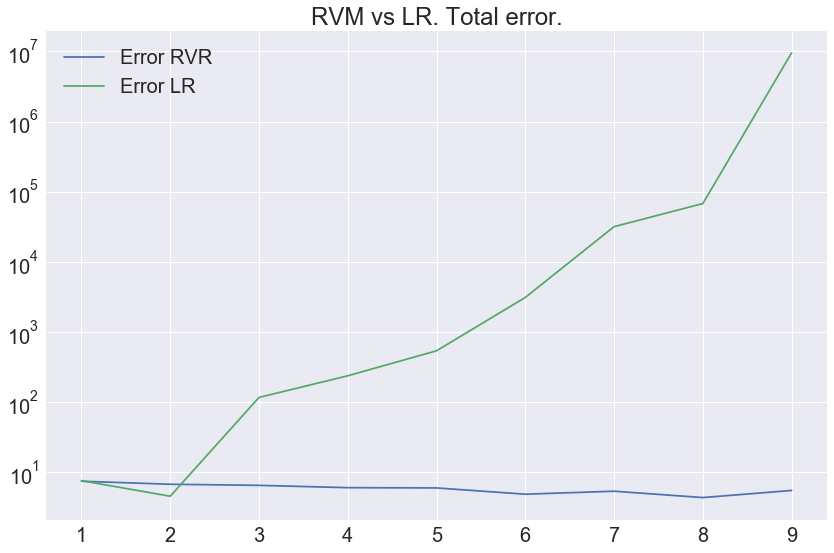

In [71]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, error_rvr, label='Error RVR')
plt.plot(degrees, error_lr, label='Error LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total error.")
plt.show()

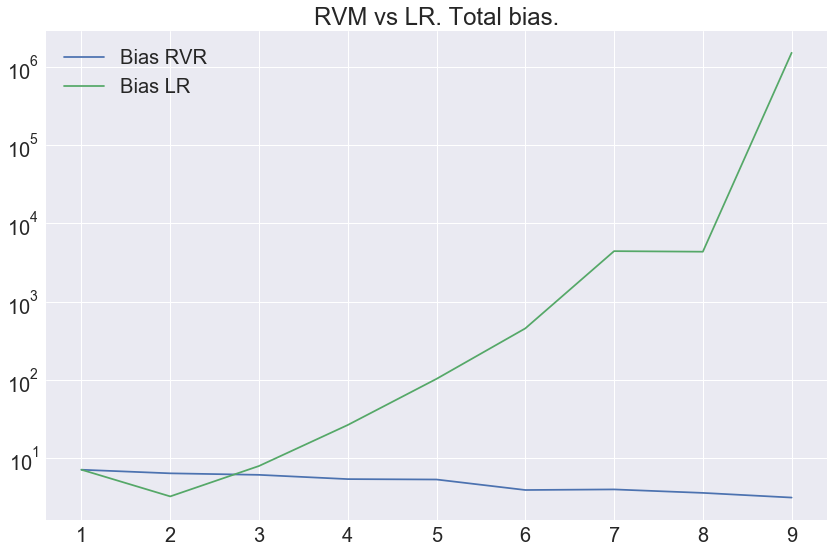

In [72]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, bias_rvr, label='Bias RVR')
plt.plot(degrees, bias_lr, label='Bias LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total bias.")
plt.show()

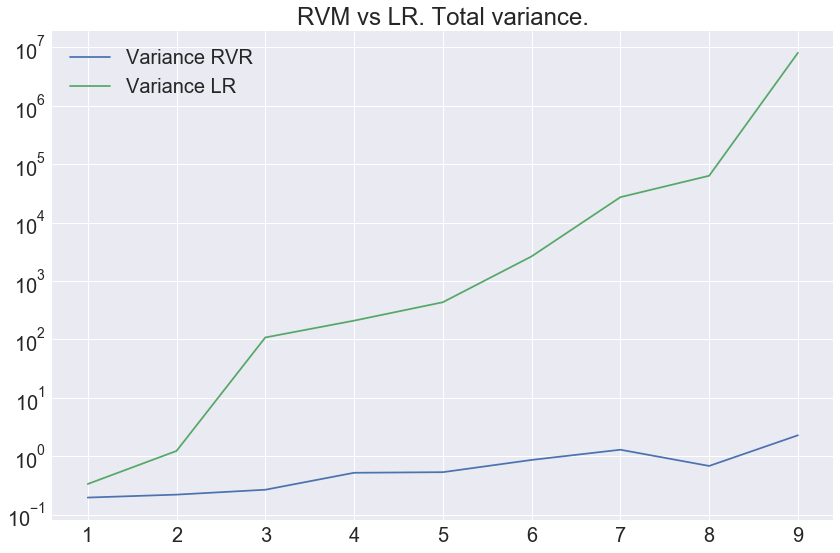

In [73]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, variance_rvr, label='Variance RVR')
plt.plot(degrees, variance_lr, label='Variance LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total variance.")
plt.show()

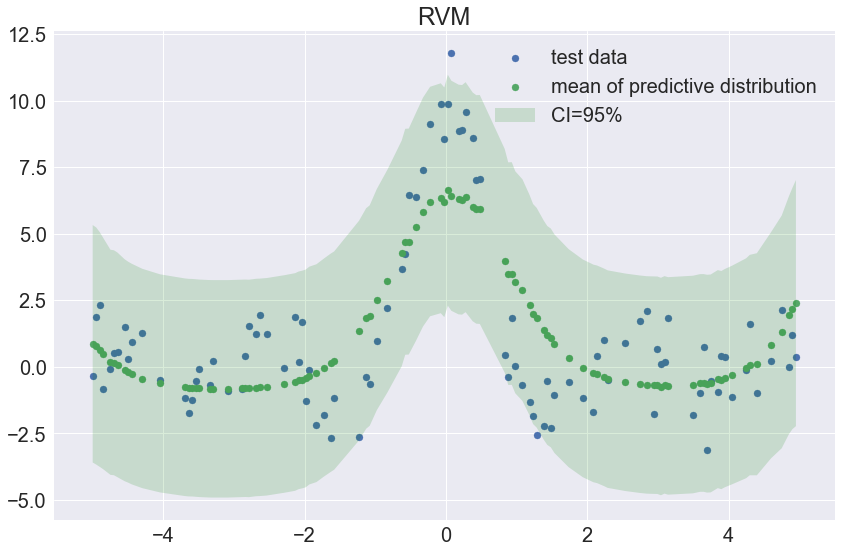

In [74]:
rvm = RVR(kernel='poly', degree=9).fit(X_train, Y_train)
Y_pred, Y_pred_std = rvm.predict_dist(X_test)

plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM")
plt.show()